REQUIRED IMPORTS

In [1]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import re
from pandas import DataFrame

• SETTING DISPLAY OPTIONS FOR PANDAS TO SHOW ALL COLUMNS AND ROWS

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

PART 1

• IMPLEMENTING THE FUNCTION COLLECT_PAGE_DATA THAT TAKES AS INPUT A BBC RECIPLE URL

• EXTRACTING REQUIRED RECIPE INFORMATION BY USING BEAUTIFUL SOUP AND JSON FILE EXTRACTION

• RETURNING A PANDAS DATAFRAME WITH REQUIRED COLUMNS USING THE VALUES EXTRACTED FROM URL

• GENERATING A CSV FILE STORING THE DATAFRAME CONTENTS

• TEST FUNCTION WITH APPROPRIATE INPUTS (BBC RECIPE URLS)

In [32]:
def collect_page_data(urls):
    if isinstance(urls, str):  # If a single URL is provided, convert it to a list containing that URL
        urls = [urls]

    dataframes = []  # List to store dataframes for each URL
    
    for url in urls:
        # Making an HTTP GET request to the provided URL
        page = requests.get(url)

        # Checking if the request was successful (status code 200)
        if page.status_code == 200:
            # Parsing the HTML content of the page using BeautifulSoup
            soup = BeautifulSoup(page.content, 'html.parser')

            # Finding the script tag containing JSON-LD data
            p = soup.find('script', {'type':'application/ld+json'})
            content = json.loads(p.string)

            # Extracting the title of the recipe
            title_tag = soup.find('h1', class_='gel-trafalgar content-title__text')
            title = title_tag.text.strip()

            # pattern to extract time in minutes from duration format
            pattern = r'PT(\d+)'

            # Extracting preparation time from JSON
            prep_time = content.get('prepTime')
            get_prep_time = 0;

            # Search for the pattern in the preparation time string
            match = re.search(pattern, prep_time)
            # If a match is found, extract the number of minutes from the matched pattern
            if match:
                number = int(match.group(1))
                get_prep_time = number
            else:
                print("No match found.")

            # Extracting hours and minutes from duration format
            pattern = r'PT(?:(\d+)H)?(?:(\d+)M)?'

            # Extracting cooking time from JSON
            cook_time = content.get('cookTime')
            get_cook_time = 0

            # Search for the pattern and extract the number of hours and minutes
            match = re.search(pattern, cook_time)
            if match:
                hours = int(match.group(1) or 0)
                minutes = int(match.group(2) or 0)
                get_cook_time = hours * 60 + minutes  # Convert hours and minutes to total minutes
            else:
                print("No match found.")

            # Calculate total time in minutes
            total_time_minutes = get_prep_time + get_cook_time

            # Convert total time to hours and minutes
            total_hours = total_time_minutes // 60
            total_minutes = total_time_minutes % 60

            # Format the total time as "H:M" with units
            total_time_format = f"{total_hours}H:{total_minutes}M"

            # Extracting image URL from JSON
            image_url = content.get('image')

            # Extracting ingredients list
            ingredients = [li.text.strip() for li in soup.find_all('li', class_='recipe-ingredients__list-item')]

            # Extracting rating value from JSON
            rating_value = content.get('aggregateRating', {}).get('ratingValue')

            # Extracting rating count from JSON
            rating_count = content.get('aggregateRating', {}).get('ratingCount')

            # Extracting recipe category
            category = content.get('recipeCategory')

            # Extracting recipe cuisine
            cuisine = content.get('recipeCuisine')

            # Extracting dietary information
            dietary_div = soup.find('div', class_='recipe-metadata__dietary')
            dietary_info = dietary_div.find('p', class_='recipe-metadata__dietary-vegetarian-text').text.strip() if dietary_div else None

            # Check if recipe is vegan
            vegan = False
            if dietary_info and 'vegan' in dietary_info.lower():
                vegan = True
                
            # Check if recipe is vegetarian
            vegetarian = False
            if dietary_info and 'vegetarian' in dietary_info.lower():
                vegetarian = True


            # Extracting URL of the recipe
            recipe_url = url

            # Creating a DataFrame to store the extracted data
            df = pd.DataFrame({
                'title': [title],
                'total_time': [total_time_format],
                'image': [image_url],
                'ingredients': [ingredients],  
                'rating_val': [rating_value],
                'rating_count': [rating_count],
                'category': [category],
                'cuisine': [cuisine],
                'diet': [dietary_info],
                'vegan': [vegan],
                'vegetarian': [vegetarian],
                'url': [recipe_url]
            })

            dataframes.append(df)  # Append the dataframe to the list

    if dataframes:  # If there are dataframes in the list
        combined_df = pd.concat(dataframes, ignore_index=True)  # Concatenate dataframes
        combined_df.to_csv('bbc_recipe.csv', index=False)  # Save concatenated dataframe to CSV
        return combined_df
    else:
        print("No data was collected.")
        return None

# Test the function with the given URLs
urls = ["https://www.bbc.co.uk/food/recipes/easiest_ever_banana_cake_42108", "https://www.bbc.co.uk/food/recipes/avocado_pasta_with_peas_31700", "https://www.bbc.co.uk/food/recipes/chicken_teriyaki_skewers_47729"]
collect_page_data(urls)  # Calling the function with the URL(s)

,title,total_time,image,ingredients,rating_val,rating_count,category,cuisine,diet,vegan,vegetarian,url
0,Easiest ever banana cake,1H:30M,[https://food-images.files.bbci.co.uk/food/rec...,[3 very ripe medium bananas (around 225g/8oz p...,4.491726,423,Cakes and baking,British,Vegetarian,False,True,https://www.bbc.co.uk/food/recipes/easiest_eve...
1,Avocado pasta with peas and mint,0H:40M,[https://food-images.files.bbci.co.uk/food/rec...,"[375g/13oz pasta, such as penne or fusilli, 1 ...",3.941176,34,Main course,None,Vegetarian,False,True,https://www.bbc.co.uk/food/recipes/avocado_pas...
2,Chicken teriyaki skewers,1H:0M,[https://food-images.files.bbci.co.uk/food/rec...,"[50ml/2fl oz soy sauce, 50ml/2fl oz mirin, 2 t...",5.000000,2,Starters & nibbles,Japanese,None,False,False,https://www.bbc.co.uk/food/recipes/chicken_ter...


REQUIRED IMPORTS

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

PART 2

QUESTION 1
 - LOADING CONTENTS OF CSV FILES
 - COMBINING CONTENTS OF CSV FILES AS SINGLE DATAFRAME
 - SHOWING SUMMARY STATISTICS
 - SUMMARY OF POSSIBLE MISSING VALUES
 - TREATING MISSING VALUES

In [6]:
# Loading the contents of both files
books_df = pd.read_csv('books_new.csv')
ratings_df = pd.read_csv('ratings.csv')

# Combining contents of both files as single dataframe
combined_df = pd.merge(ratings_df, books_df, on='bookId')
combined_df.to_csv('combined.csv',)

#Summary of possible missing values
print("\nSummary of possible missing values")
missing_values_summary = combined_df.isnull().sum()
print(missing_values_summary)

# Treating missing values
combined_df.set_index("bookId", inplace= True)
treatedDataframe_df= combined_df.fillna({
    'user_id':0,
    'rating':"Missing",
    'Title':"Missing",
    'Author':"Missing",
    'Genre':"Missing",
    'SubGenre':"missing",
    'Height': 0.00,
    'Publisher':"Missing"
})

# Treating books_df missing values for question 5
books_df.set_index("bookId", inplace= True)
books_df.fillna({
    'Title':"Missing",
    'Author':"Missing",
    'Genre':"Missing",
    'SubGenre':"missing",
    'Height': 0.00,
    'Publisher':"Missing"
},inplace=True)

#Summary statistics of combined dataframe
print("\nSummary statistics")
summary_stats = combined_df.describe()
print(summary_stats)

# Saving treated data to treatedDataframe
treatedDataframe_df.to_csv('treatedDataframe_df')


Summary of possible missing values
bookId          0
user_id         0
rating          0
Title           0
Author       2400
Genre           0
SubGenre        0
Height          0
Publisher    9600
dtype: int64

Summary statistics
            user_id        rating        Height
count  21100.000000  21100.000000  21100.000000
mean   24429.586493      3.842891    206.056872
std    14998.877003      1.064759     26.765126
min       35.000000      1.000000    160.000000
25%    11854.000000      3.000000    180.000000
50%    21733.000000      4.000000    199.000000
75%    36099.000000      5.000000    230.000000
max    53381.000000      5.000000    283.000000


QUESTION 2
- CALCULATE AVERAGE RATINGS FOR EACH BOOK 
- TOP 10 HIGHEST RATED BOOKS
- 95% CONFIDENCE INTERVAL USING BOOTSTRAP METHOD WITH 1000 SAMPLES OF SIZE 100

In [8]:
# Grouping by bookId and calculating the average ratings for each book
average_ratings = treatedDataframe_df.groupby('bookId')['rating'].mean()

# Sort and display the top 10 books by their average rating
print("10 highest book ratings")
top_10_books = average_ratings.sort_values(ascending=False).head(10)

# Set a sample size and number of samples to generate
sample_size = 100
num_bootstrap_samples = 1000

# Randomly generating bootstrap samples from average_ratings with replacement
bootstrap_samples = [np.random.choice(average_ratings, size=sample_size, replace=True) \
                     for _ in range(num_bootstrap_samples)]

# Calculating the 95% confidence interval using the bootstap_means
bootstrap_means = [np.mean(bootstrap_sample) for bootstrap_sample in bootstrap_samples]

confidence_interval_bootstrap = np.percentile(bootstrap_means, [2.5, 97.5])


print(top_10_books)
print(f"\nConfidence Interval (Bootstrap): {confidence_interval_bootstrap}")

10 highest book ratings
bookId
4      4.46
144    4.44
39     4.42
89     4.36
135    4.35
87     4.33
168    4.33
141    4.32
47     4.32
31     4.29
Name: rating, dtype: float64

Confidence Interval (Bootstrap): [3.7765875 3.9046125]


QUESTION 3
- ADDING EXTRA COLUMN FOR RATING COUNT AND AVERAGE RATING
- COMMENT ON RELATIONSHIP BETWEEN AVERAGE RATING AND RATING COUNT
- THRESHOLD FOR NUMBER OF RATINGS UNDER WHICH RATING CAN BE CONSIDERED AS NOT SIGNIFICANT

In [9]:
# Adding columns rating count and average rating
rate_stat = treatedDataframe_df.groupby('bookId')['rating'].agg(['count','mean'])
rate_stat.columns = ['Rating Count','Average Rating']

# Merging with the appropriate dataframe books_df to include rating stats
books_df = pd.merge(books_df, rate_stat, on='bookId', how='left')

# Saving the updated dataframe to books_df
books_df.to_csv('books_df.csv', index=False)

# Printing the updated Dataframe
books_df

,Title,Author,Genre,SubGenre,Height,Publisher,Rating Count,Average Rating
bookId,,,,,,,,
1,Fundamentals of Wavelets,"Goswami, Jaideva",tech,signal_processing,228,Wiley,100,4.24
2,Data Smart,"Foreman, John",tech,data_science,235,Wiley,100,4.21
3,God Created the Integers,"Hawking, Stephen",tech,mathematics,197,Penguin,100,3.09
4,Superfreakonomics,"Dubner, Stephen",science,economics,179,HarperCollins,100,4.46
5,Orientalism,"Said, Edward",nonfiction,history,197,Penguin,100,3.89
6,"Nature of Statistical Learning Theory, The","Vapnik, Vladimir",tech,data_science,230,Springer,100,4.09
7,Integration of the Indian States,"Menon, V P",nonfiction,history,217,Orient Blackswan,100,3.92
8,"Drunkard's Walk, The","Mlodinow, Leonard",science,mathematics,197,Penguin,100,3.83
9,Image Processing & Mathematical Morphology,"Shih, Frank",tech,signal_processing,241,CRC,100,3.35


COMMENT ON RELATIONSHIP BETWEEN AVERAGE RATING AND RATING COUNT
- It is difficult to comment on the relationship between Average Rating and Rating Count as all the data values in the Rating Count column are constant at 100. 
- This means we cannot tell if some of the data values in Average Rating are inaccurate or are affected by outliers as there is 100 values used for each Average Rating.

JUSTIFYING THE THRESHOLD FOR NUMBER OF RATINGS UNDER WHICH RATING CAN BE CONSIDERED AS NOT SIGNIFICANT
- All of the average ratings can be considered as significant as each book has been rated 100 times. This means that no data value in Average Rating is less significant than the other. Hence, there is no threshold.

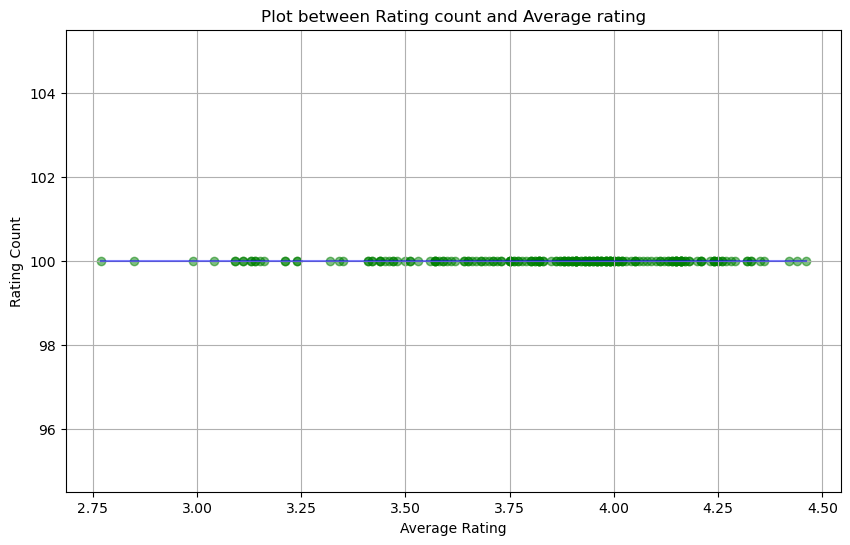

In [11]:
# Plotting the graph for rating count against average rating
sorted_books_df = books_df.sort_values(by='Average Rating')

plt.figure(figsize=(10, 6))
plt.scatter(sorted_books_df['Average Rating'], sorted_books_df['Rating Count'], color='green', alpha=0.5)

plt.plot(sorted_books_df['Average Rating'], sorted_books_df['Rating Count'], color='blue', alpha=0.5)

plt.title('Plot between Rating count and Average rating')
plt.xlabel('Average Rating')
plt.ylabel('Rating Count')
plt.grid(True)
plt.show()

QUESTION 4
- CREATE BINARY RATING METHOD
- APPLY BINARY RATING METHOD TO 'AVERAGE RATING' COLUMN TO BOOKS_DF
- ADD A COLUMN 'COMBINED FEATURES' TO BOOKS_DF 
- COMPUTE COSINE SIMILARITY FORMED BY 'COMBINED FEATURES'

In [13]:
# Binary rating method
def binary_rating(r):
    if r >= 3.6:
        return 1
    else:
        return -1
    
# Applying binary_rating method to the column "Average Rating" of dataset books_df   
books_df['Average Rating'] = books_df.apply(lambda row: binary_rating(row['Average Rating']), axis=1)

# Selecting the features for the "combined_features"
features = ['Title','Author','Genre','SubGenre','Publisher']

# Filling any missing values and converting the features into a string
for combined_feature in features:
    books_df[combined_feature] = books_df[combined_feature].fillna('').astype(str)

# Create a new column called 'combined features' with all the selected features
books_df['combined_features'] = books_df[features].apply(lambda x: ' '.join(x), axis=1)
books_df.head()

# Applying CountVectorizer() class and computing the cosine similarity matrix
count_vectorizer = CountVectorizer()
dtm = count_vectorizer.fit_transform(books_df['combined_features'])
cosine_sim_matrix=cosine_similarity(dtm)
print(cosine_sim_matrix)

[[1.         0.26726124 0.11785113 ... 0.         0.         0.        ]
 [0.26726124 1.         0.12598816 ... 0.         0.         0.        ]
 [0.11785113 0.12598816 1.         ... 0.         0.12598816 0.        ]
 ...
 [0.         0.         0.         ... 1.         0.42857143 0.42857143]
 [0.         0.         0.12598816 ... 0.42857143 1.         0.42857143]
 [0.         0.         0.         ... 0.42857143 0.42857143 1.        ]]


QUESTION 5
- FUNCTION VEC_SPACE_METHOD TO RETURN TOP 10 SIMILAR BOOKS TO CHOSEN BOOKID

In [15]:
def vec_space_method(bookId, cosine_sim_matrix, books_df):

    # Find index of bookId in books_df
    book_index = books_df.index.get_loc(bookId)

    # Extract similarity scores for chosen book and rest of books
    similar_scores = list(enumerate(cosine_sim_matrix[book_index]))

    # Sort books based on similarity scores in descending order
    similar_scores = sorted(similar_scores, key=lambda x: x[1], reverse=True)

    # Get similarity scores of top 10 similar books
    similar_scores = similar_scores[1:11]

    # Get book indices and select the book IDs and similarity score
    book_indices = [i[0] for i in similar_scores]
    similar_books = books_df.iloc[book_indices]
    similarity_scores = [similar_scores[i][1] for i in range(len(similar_scores))]

    # Return top 10 similar books and similarity scores
    res = similar_books.copy()
    res['Similar'] = similarity_scores

    return res

# Testing with bookId 29, this is Vol I The Complete Sherlock Holmes so it should return Vol II as most similar
bookId = 172
vec_space_method(bookId, cosine_sim_matrix, books_df)

,Title,Author,Genre,SubGenre,Height,Publisher,Rating Count,Average Rating,combined_features,Similar
bookId,,,,,,,,,,
173,Superman Earth One - 2,Missing,fiction,comic,258,Missing,100,1,Superman Earth One - 2 Missing fiction comic M...,1.000000
169,Batman Earth One,Missing,fiction,comic,265,Missing,100,-1,Batman Earth One Missing fiction comic Missing,0.888889
168,Flashpoint,Missing,fiction,comic,265,Missing,100,1,Flashpoint Missing fiction comic Missing,0.755929
176,"Death of Superman, The",Missing,fiction,comic,258,Missing,100,1,"Death of Superman, The Missing fiction comic M...",0.737865
165,Final Crisis,Missing,fiction,comic,257,Missing,100,1,Final Crisis Missing fiction comic Missing,0.707107
238,Batman Handbook,Missing,fiction,comic,270,Missing,100,-1,Batman Handbook Missing fiction comic Missing,0.707107
166,"Killing Joke, The",Missing,fiction,comic,283,Missing,100,-1,"Killing Joke, The Missing fiction comic Missing",0.666667
170,Crisis on Infinite Earths,Missing,fiction,comic,258,Missing,100,-1,Crisis on Infinite Earths Missing fiction comi...,0.632456
178,Batman: The Long Halloween,Missing,fiction,comic,258,Missing,100,1,Batman: The Long Halloween Missing fiction com...,0.632456


QUESTION 6
- FUNCTION 'KNN_SIMILARITY' TO RETURN TOP 10 SIMILAR BOOKS TO CHOSEN BOOKID
- USED STACKOVERFLOW TO FIND OUT WHY TABLE WAS RETURNING CHOSEN BOOK AS PART OF RESULT

In [16]:
# Referencing a new CountVectorizer for question 6
count_vec = CountVectorizer() 
dtm2 = count_vec.fit_transform(books_df['combined_features'])

# Finding 10 nearest neighbours
model_knn = NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=11)
model_knn.fit(dtm2)

def knn_similarity(bookId, books_df, model_knn, dtm2):
    
    # Locate the index from books_df which is bookId
    book_index = books_df.index.get_loc(bookId)
    
    # Returning distances and indices of the nearest neighbours
    dist, ind = model_knn.kneighbors(dtm2[book_index:book_index+1], n_neighbors=11)
    
    # Removing the input book
    similar_indices = ind.flatten()[1:] 
    
    # Finding books from the indices and converting to a list
    similar_books_ids = books_df.iloc[similar_indices].index.tolist()
    
    return similar_books_ids

# Testing with bookId of 29
test_book_id = books_df.index[29]  

similar_books_ids = knn_similarity(test_book_id, books_df, model_knn, dtm2)

print("Recommendation for 10 similar books to", books_df.loc[test_book_id, 'Title'])
for bookId in similar_books_ids:
      print(f"Book id {bookId}: {books_df.loc[bookId,'Title']}")

Recommendation for 10 similar books to Complete Sherlock Holmes, The - Vol II
Book id 29: Complete Sherlock Holmes, The - Vol I
Book id 16: Trial, The
Book id 108: Hunchback of Notre Dame, The
Book id 58: Catch 22
Book id 55: Brethren, The
Book id 12: Slaughterhouse Five
Book id 32: Pillars of the Earth, The
Book id 71: Amulet of Samarkand, The
Book id 232: Prince, The
Book id 28: Outsider, The


QUESTION 7
- CONSIDER TEST SETS COMPOSED OF 4 USERS
- EVALUATE BOTH RECOMMENDER SYSTEMS BUILT IN PART 2 IN TERMS OF COVERAGE AND PERSONALISATION

In [17]:
#Create a dictionary to obtain recommendations for each User
vector_space_recommendations = []
knn_recommendations = []

# User preferences mapping
user_preferences = {
    1: 1,  # User 1 likes book with book ID 1
    2: 5,  # User 2 likes book with book ID 5
    3: 10,  # User 3 likes book with book ID 10
    4: 11,  # User 4 likes book with book ID 11
}

# Iterate over each user and their preferred book
for user_id, preferred_book_id in user_preferences.items():
    # Get recommendations using the vector space method for the preferred book ID
    vector_space_rec = vec_space_method(preferred_book_id, cosine_sim_matrix, books_df)
    vector_space_recommendations.extend(vector_space_rec)

    # Get recommendations using the KNN method for the preferred book ID
    knn_rec = knn_similarity(preferred_book_id, books_df, model_knn, dtm2)
    knn_recommendations.extend(knn_rec)

# Calculate Coverage for Vector Space Method
unique_vector_space_recommendations = set(vector_space_recommendations)
total_unique_books = len(books_df)  # Total number of unique books in the dataset
vector_space_coverage = len(unique_vector_space_recommendations) / total_unique_books * 100

# Calculate Coverage for KNN Method
unique_knn_recommendations = set(knn_recommendations)
knn_coverage = len(unique_knn_recommendations) / total_unique_books * 100

# Print Coverages for each models
print("Vector Space Method Coverage:", vector_space_coverage, "%")
print("KNN Method Coverage:", knn_coverage, "%")

Vector Space Method Coverage: 4.739336492890995 %
KNN Method Coverage: 15.639810426540285 %


EVALUATION
- The results of the coverage implies that the KNN method has more coverage than the vector space method which means it offers a greter variety of recommendations to the user. This suggest that the user would recieve a broader range of suggestions but doesnt neccesarily mean that the recommended book would be liked by the user. Even though the coverage is low for the vector method, it may be more specific to the users taste.

In [18]:
# neccesary imports
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Obtain Recommendations for Each User
vector_space_recommendations = []
knn_recommendations = []

# User preferences mapping
user_preferences = {
    1: 1,  # User 1 likes book with book ID 1
    2: 5,  # User 2 likes book with book ID 5
    3: 10,  # User 3 likes book with book ID 10
    4: 11,  # User 4 likes book with book ID 11
}

# Iterate over each user and their preferred book
for user_id, preferred_book_id in user_preferences.items():
    
    # Get recommendations using the vector space method for the preferred book ID
    vector_space_rec = vec_space_method(preferred_book_id, cosine_sim_matrix, books_df)
    vector_space_recommendations.append(vector_space_rec)

    # Get recommendations using the KNN method for the preferred book ID
    knn_rec = knn_similarity(preferred_book_id, books_df, model_knn, dtm2)
    knn_recommendations.append(knn_rec)

# Calculate Personalization for Vector Space Method
if vector_space_recommendations:
    # Extract only the book IDs from the recommendation lists
    vector_space_rec_ids = [book_id for book_list in vector_space_recommendations for book_id in book_list]
    unique_vector_space_rec_ids = set(vector_space_rec_ids)
    num_unique_books = len(unique_vector_space_rec_ids)
    num_total_books = len(vector_space_rec_ids)
    
    # Calculate personalization score for the vector space method
    personalization_vector_space = 1 - (num_unique_books / num_total_books)
else:
    personalization_vector_space = None

# Calculate Personalization for KNN Method
if knn_recommendations:
    # Extract only the book IDs from the recommendation lists
    knn_rec_ids = [book_id for book_list in knn_recommendations for book_id in book_list]
    unique_knn_rec_ids = set(knn_rec_ids)
    num_unique_books_knn = len(unique_knn_rec_ids)
    num_total_books_knn = len(knn_rec_ids)
    
    # Calculate personalization score for the KNN method
    personalization_knn = 1 - (num_unique_books_knn / num_total_books_knn)
else:
    personalization_knn = None

# Print Personalization Scores
print("Vector Space Method Personalization:", personalization_vector_space)
print("KNN Method Personalization:", personalization_knn)

Vector Space Method Personalization: 0.75
KNN Method Personalization: 0.17500000000000004


EVALUATION
- The personalization scores indicates that the Vector Space Method has more personalisation compared to the KNN Method. 
- This implies that the recommendations generated by the Vector Space Method are more tailored to individual user preferences, resulting in less overlap between recommended lists across different users.The KNN Method has a much lower personalization score of 0.175, indicating that the recommendations generated by this method are less unique to each user. The lower personalisation suggests that their book suggestions are very similar in the recommended lists across different users.
- In previous tests KNN has a higher coverage which then explains why the personalisation is low and vice versa for vector method.

QUESTION 8
- WRITING A FUNCTION "PREDICT_LIKE" WHICH PREDICTS WHETHER USER WOULD LIKE THAT BOOK OR NOT USING KNN ALGORITHM
- INVESTIGATING HOW ACCURATE OUR PREDICTIONS ARE
- USED A TEST SET TO INVESTIGATE THE ACCURACY OF THE PREDICTIONS

In [25]:
# relevant imports
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

def predict_like_knn(book_df, user_id, book_id):
    # Extract user-item ratings matrix
    ratings_matrix = csr_matrix(book_df.pivot_table(
        index='bookId',              # Using 'bookId' as index
        columns='user_id',           # Using 'user_id' as columns
        values='rating',             # Using 'rating' as values
        fill_value=0))               # Fill missing values with 0  
    
    # Creating KNN model
    model_knn = NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=20, n_jobs=-1)
    model_knn.fit(ratings_matrix)
    
    # To get the k neighbors of a given book (Find the most similar books to the given book.)
    distances, indices = model_knn.kneighbors(ratings_matrix[book_id], n_neighbors=10)
    
    # Extract user ratings for these similar books
    similar_books_ratings = ratings_matrix[indices.flatten(), :].toarray()
    
    # Filter out ratings of the current user and books not rated by the user
    user_ratings_for_similar_books = similar_books_ratings[:, user_id]
    user_ratings_for_similar_books = user_ratings_for_similar_books[user_ratings_for_similar_books > 0]
    
    # Calculate the average rating of the similar books rated by the user
    avg_rating_similar_books = user_ratings_for_similar_books.mean() if len(user_ratings_for_similar_books) > 0 else 0
    
    # Get user rating for the specified book
    user_rating_book = ratings_matrix[book_id, user_id]
    
    # Predict whether the user would like the book or not
    if user_rating_book > 0:  
        predicted_like = 1
    else:
        # Predict like if the user has rated similar books high
        predicted_like = 1 if avg_rating_similar_books >= 3.6 else 0
    
    return predicted_like
    

#test set form question 7 used to test accuracy
user_preferences = {
    1: 1,  # User 1 likes book with book ID 1
    2: 5,  # User 2 likes book with book ID 5
    3: 10,  # User 3 likes book with book ID 10
    4: 11,  # User 4 likes book with book ID 11
}
correct_predictions= 0

#The below code tells us that the model has only successfully predicted that user 2 would like book 5 and has wrongly prdicted the likes for the other users 
for user_id, preferred_book_id in user_preferences.items():
    predicted_like = predict_like_knn(treatedDataframe_df, user_id,  preferred_book_id)
    print("User", user_id, "would like book", preferred_book_id) if predicted_like == 1 else print("User", user_id, "would not like book", preferred_book_id)

User 1 would not like book 1
User 2 would like book 5
User 3 would not like book 10
User 4 would not like book 11


In [31]:
correct_predictions = 0
# Iterate over each user and their preferred book, calculating the percentage of accurate predictions on the test set given in question 7
for user_id, preferred_book_id in user_preferences.items():
    predicted_like = predict_like_knn(treatedDataframe_df, user_id, preferred_book_id)
    if predicted_like == 1 and preferred_book_id == user_preferences[user_id]:
        correct_predictions += 1
# Calculate accuracy of the algorithm
accuracy = correct_predictions / len(user_preferences) * 100
print("Number of correct predictions:", correct_predictions)
print("Accuracy:", accuracy, "%")

Number of correct predictions: 1
Accuracy: 25.0 %


INVESTIGATION
- This tells us the the model is 25% accurate. 
- The low level is expected as the personalisation level for KNN method is really low which means the recommender system doesn't recommend unique books personal to the user, but rather has a higher coverage leading to a wide range of suggestions.